In [1]:
%matplotlib inline
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

np.random.seed(0)

In [2]:
data = pd.read_csv('../data/train_month_3_with_target.csv',parse_dates = [29,30,32], index_col = 'client_id')
data.dtypes

homebanking_active                            int64
has_homebanking                               int64
has_insurance_21                              int64
has_insurance_23                              int64
has_life_insurance_fixed_cap                  int64
has_life_insurance_decreasing_cap             int64
has_fire_car_other_insurance                  int64
has_personal_loan                             int64
has_mortgage_loan                             int64
has_current_account                           int64
has_pension_saving                            int64
has_savings_account                           int64
has_savings_account_starter                   int64
has_current_account_starter                   int64
bal_insurance_21                              int64
bal_insurance_23                              int64
cap_life_insurance_fixed_cap                  int64
cap_life_insurance_decreasing_cap             int64
prem_fire_car_other_insurance                 int64
bal_personal

In [3]:
#non sample-dependent transformations
date_features = data.select_dtypes(include = ['datetime64'])
data['customer_since_all_years'] = (2018-data.customer_since_all.dt.year)
data['customer_since_bank_years'] = (2018-data.customer_since_bank.dt.year)
data['customer_age'] = (2018-data.customer_birth_date.dt.year)

#initialise target and select features

selected_col = ['homebanking_active'
              ,'has_homebanking'
              ,'bal_mortgage_loan'
              ,'has_life_insurance_decreasing_cap'
              ,'has_mortgage_loan'
              ,'has_current_account'
              ,'cap_life_insurance_decreasing_cap'
              ,'bal_savings_account'
              ,'bal_current_account'
              ,'has_personal_loan'
              ,'bal_personal_loan'
              ,'customer_since_all_years'
              ,'customer_since_bank_years'
              ,'customer_age'   
         ]
y = data.target
X = data.drop(columns = ['target'])
X = X[selected_col]
print(X.dtypes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

homebanking_active                     int64
has_homebanking                        int64
bal_mortgage_loan                      int64
has_life_insurance_decreasing_cap      int64
has_mortgage_loan                      int64
has_current_account                    int64
cap_life_insurance_decreasing_cap      int64
bal_savings_account                    int64
bal_current_account                    int64
has_personal_loan                      int64
bal_personal_loan                      int64
customer_since_all_years             float64
customer_since_bank_years            float64
customer_age                           int64
dtype: object


In [4]:
X_train.columns

Index(['homebanking_active', 'has_homebanking', 'bal_mortgage_loan',
       'has_life_insurance_decreasing_cap', 'has_mortgage_loan',
       'has_current_account', 'cap_life_insurance_decreasing_cap',
       'bal_savings_account', 'bal_current_account', 'has_personal_loan',
       'bal_personal_loan', 'customer_since_all_years',
       'customer_since_bank_years', 'customer_age'],
      dtype='object')

In [12]:
#sample dependent preprocessing
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer


kbin = KBinsDiscretizer(n_bins=5, encode='ordinal')
binner = Pipeline(steps=[
    ('impute',SimpleImputer(missing_values=np.nan, strategy='mean'))
#     ,('bin',KBinsDiscretizer(n_bins=5, encode='ordinal'))
])

columns_to_bin = ['customer_since_all_years','customer_since_bank_years','customer_age']
preprocessor = ColumnTransformer(
    transformers=[
        ("bin", binner, columns_to_bin)     
    ],
    remainder = "passthrough"
)


In [13]:
#balance classes 50:50
smt = SMOTE(random_state=42)

#classifier
rf = RandomForestClassifier(max_depth=5,n_estimators = 100,random_state=0)

#pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor),("balancer", smt), ("classifier", rf)]
)

# train 
clf = pipe.fit(X_train,y_train)

In [14]:
y_pred_test = clf.predict(X_test)
y_pred_test_probs = clf.predict_proba(X_test)
y_pred_test_probs = [x[1] for x in y_pred_test_probs]

# y_pred_250 
y_pred_250 = pd.DataFrame({'y':y_test,'y_pred':y_pred_test,'y_pred_prob':y_pred_test_probs}).sort_values(by ='y_pred_prob',ascending=False)
y_pred_250 = y_pred_250.head(250)
y_pred_250

,y,y_pred,y_pred_prob
client_id,,,
be069427de1e04e9e840a042ffd475e2,0,1,0.767302
417e6f66c7c8e0629e9f877f04f4ebd7,1,1,0.767302
3155f78c1d686a28668d32d6bfc433c0,0,1,0.767302
ae6ff1d5a129a7398bf3c1b4f097c9d9,0,1,0.767302
4b2026034f1ffb9b7dc4dc8a6d52d5bf,0,1,0.767302
...,...,...,...
9b084c0e39a525543dd017854e560a18,0,1,0.748489
a9f845e4c27767232a9beb0751fa7e8f,0,1,0.746966
298a9b574b015c8d84b59c52443dbfb0,0,1,0.746670


model accuracy score: 0.831


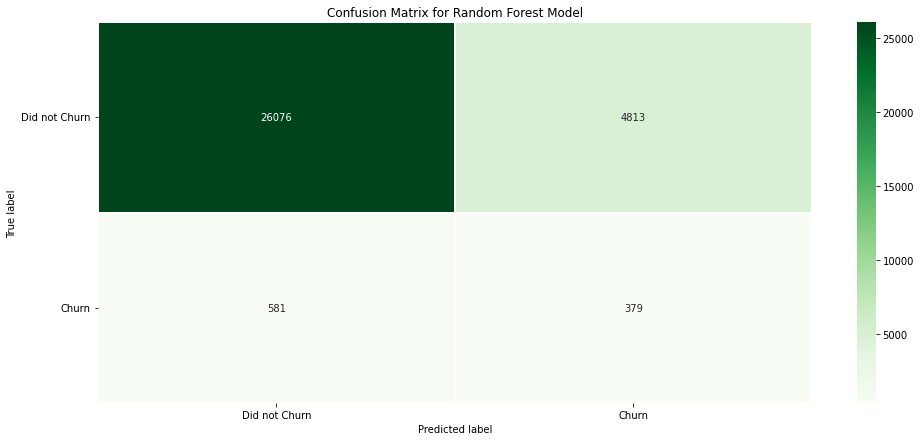

               precision    recall  f1-score   support

Did not Churn       0.98      0.84      0.91     30889
        Churn       0.07      0.39      0.12       960

     accuracy                           0.83     31849
    macro avg       0.53      0.62      0.51     31849
 weighted avg       0.95      0.83      0.88     31849



In [15]:
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, classification_report,auc
from sklearn.metrics import roc_curve,auc

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, 
            annot=True,
            fmt='g',
            cmap=plt.cm.Greens, 
            linewidths=0.2)

# Add labels to the plot
class_names = ['Did not Churn', 'Churn']
tick_marks = np.arange(len(class_names))+0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')

print("model accuracy score: %.3f" % clf.score(X_test, y_test))
plt.show()

print(classification_report(y_test, y_pred_test,target_names = class_names))

               precision    recall  f1-score   support

Did not Churn       0.00      0.00      0.00       223
        Churn       0.11      1.00      0.19        27

     accuracy                           0.11       250
    macro avg       0.05      0.50      0.10       250
 weighted avg       0.01      0.11      0.02       250



/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/BADM/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5

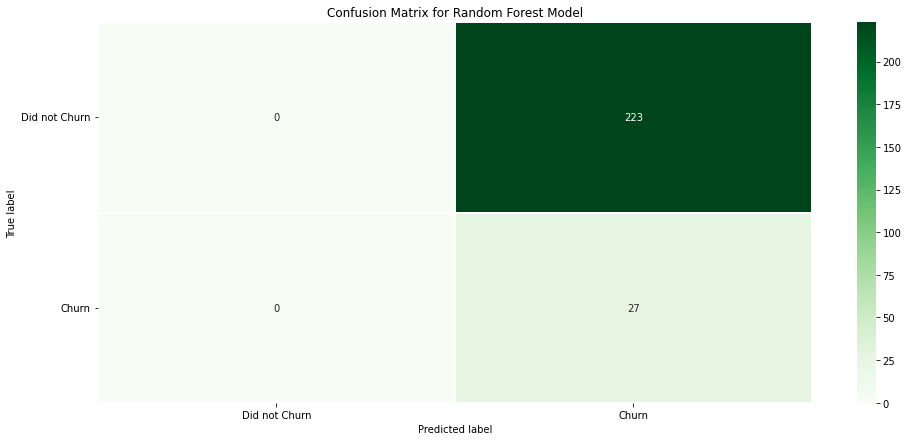

In [16]:
# At top 250
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, classification_report
from sklearn.metrics import roc_curve,auc

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_pred_250.y, y_pred_250.y_pred)

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, 
            annot=True,
            fmt='g',
            cmap=plt.cm.Greens, 
            linewidths=0.2)

# Add labels to the plot
class_names = ['Did not Churn', 'Churn']
tick_marks = np.arange(len(class_names)) +0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')

print(classification_report(y_pred_250.y, y_pred_250.y_pred,target_names = class_names))

fpr, tpr, thresholds = roc_curve(y_pred_250.y, y_pred_250.y_pred)
auc(fpr, tpr)